# Filtering lithology by formation

In this recipe, we'll apply non-regularly sample point data to stratigraphic intervals. It's a kind of intellegent upscaling.

## Point data

From the recipe, [Handling sidewall core data](https://github.com/agile-geoscience/recipes/blob/master/Handling%20sidewall%20core%20data.ipynb), we'll start by making a striplog representing sidewall core porosity.

In [36]:
from striplog import Striplog, Lexicon, Legend
% matplotlib inline

Some things really are point data. Sort of like a log, but irregular, more discrete. For instance we may have some porosity measurements of sidewall core plugs.

In [37]:
data_csv = """top, density, porosity, remarks
650, 2100, 0.100,
700, 2150, 0.002,
750, 2150, 0.015,
825, 2200, 0.027,
875, 2200, 0.043,
925, 2300, 0.220,
1000, 2200, 0.085,
1050, 2220, 0.065,
1100, 2225, 0.054,
1150, 2200, 0.063,
1200, 2300, 0.064,
1250, 2375, 0.073,
1300, 2400, 0.082, broken sample
1350, 2425, 0.192,
1400, 2575, 0.143,
1500, 2425, 0.192,
1505, 2376, 0.252,
1510, 2435, 0.157,
1550, 2424, 0.150,
1575, 2465, 0.095,
1600, 2400, 0.129,
"""

You must specify `points=True` otherwise Striplog will 'fill in' and create the bases for you, based on the next top.

In [38]:
swc_data = Striplog.from_csv_text(data_csv, points=True)

When we pass this 'striplog' into `welly.plot()`, it gets treated as a set of points.

In [39]:
import numpy as np
phi = np.array([i.primary.porosity for i in swc_data])

In [40]:
z = np.array([i.top.middle for i  in swc_data])
z

array([  650.,   700.,   750.,   825.,   875.,   925.,  1000.,  1050.,
        1100.,  1150.,  1200.,  1250.,  1300.,  1350.,  1400.,  1500.,
        1505.,  1510.,  1550.,  1575.,  1600.])

## Stratigraphic data

Read a simple csv of tops into a list.

In [44]:
topsfile = 'data/tops/P-129_tops.csv'

In [45]:
import csv

def get_tops(fname, wellid):
    """
    Get all the tops corrsponding to the first column name of well
    """
    tops = ''
    with open(fname, 'r') as f:
        for line in f.readlines():
            row = line.strip().split(',')
            if row[0] == wellid:
                name = row[1]
                md = row[5]
                tops += md + ', ' + str(name) +  '\n '
    return tops

In [46]:
topslist = get_tops(topsfile, 'P-129')

In [47]:
l = Lexicon.default()
l.formation = [r'\w+']

In [48]:
formations = Striplog.from_descriptions(topslist, lexicon=l, order='auto')
for frm in formations:
    print(frm.summary(fmt='{formation!t}'), frm.top.middle, '-',frm.base.middle)

107.71 m of Lower Windsor 698.33 - 806.04
140.48 m of Horton 806.04 - 946.52
959.83 m of Horton Bluff 946.52 - 1906.35
32.11 m of Maguma 1906.35 - 1938.46
1.00 m of Td 1938.46 - 1939.46


We need to make a legend for our formations, otherwise we won't be able to see it.

In [49]:
strat_str = """colour,  width, comp formation
        #FFFFFF, 1, none
        #9999ff, 1, lower windsor
        #ffcc00, 1, horton
        #cc6600, 1, horton bluff
        #660033, 1, meguma
"""

In [50]:
tops_legend = Legend.from_csv(strat_str)

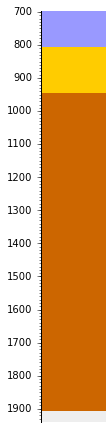

In [51]:
formations.plot(legend=tops_legend, aspect=4.0)

## Make a `striplog` from image

In [52]:
imgfile = "data/images/P-129_280_1935.png"

In [53]:
legend = Legend.default(name='nsdoe')

In [54]:
top, base = 280.0, 1935.0
strip = Striplog.from_image(imgfile, top, base, legend=legend)

## Create a `well` object 

In [55]:
from welly import Well, Curve

In [56]:
well = Well.from_las('data/las/P-129_out.LAS')

In [57]:
curve_legend_csv = """colour,lw,xscale,curve mnemonic
#006400,1.0,linear,GR
#000000,1.0,log,RLA5
#000000,1.0,linear,RHOB
#CCFFCC,1.0,linear,NPHI_SAN
blue,1.0,linear,DT
green,1.0,linear,DTS
"""
curve_legend = Legend.from_csv(curve_legend_csv)

Add our `formations` and `swc_porosity` to the `well`

In [58]:
well.data['FM'] = formations
well.data['SWC_PHI'] = swc_data
well.data['strip'] = strip

In [59]:
# let's look a these tracks

In [60]:
complete_legend = tops_legend + curve_legend + legend

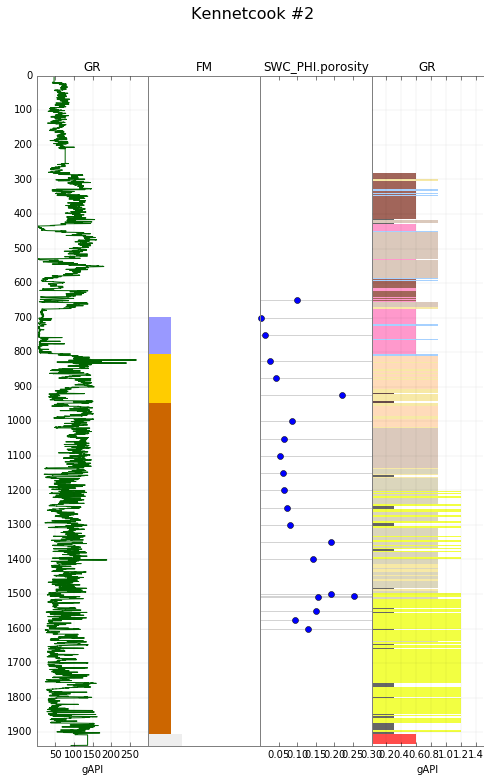

In [61]:
tracks = ['GR','FM','SWC_PHI.porosity',['strip','GR']]
well.plot(tracks=tracks, legend=complete_legend)

# Apply point data to Formation intervals

In [69]:
a = well.data['strip']
b = well.data['FM']
c = well.data['SWC_PHI']

In [75]:
sands = a.find('sandstone')

In [76]:
b

Striplog(5 Intervals, start=698.33, stop=1939.46)

In [77]:
c

Striplog(21 Intervals, start=1600.0, stop=650.0)

In [111]:
ShalyHort = well.data['strip'].find('mud').intersect(well.data['FM'].find('Horton'))

In [112]:
well.data['Horton Shales']=ShalyHort

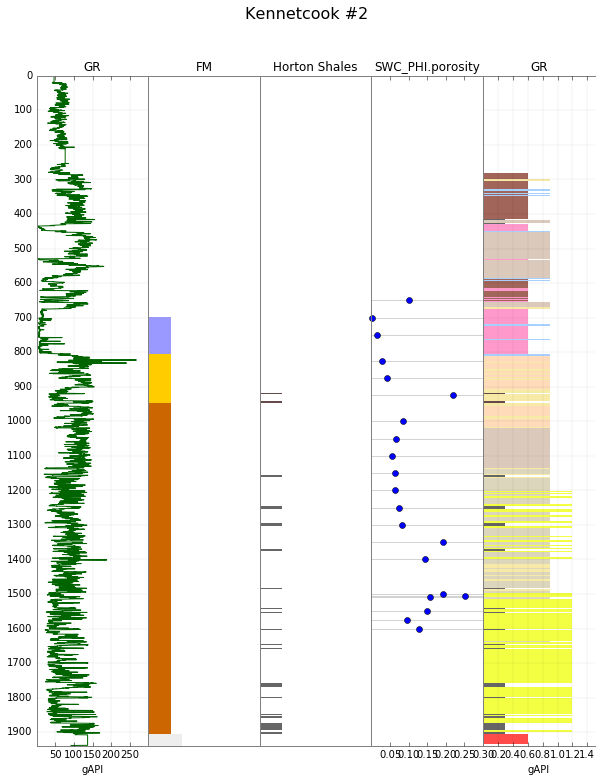

In [113]:
tracks = ['GR','FM','Horton Shales','SWC_PHI.porosity',['strip','GR']]
well.plot(tracks=tracks, legend=complete_legend)